Implementação dos algoritmos de Filtragem Espacial e Análise de Textura




Função para leitura da Imagem:

In [70]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2

def lerimg(img, printar=False):
    with open(img) as image_file:
      image=image_file.readlines()
    assert image[0][:2] == 'P2', "Imagem com formato inválido"
    img=[]
    for i in image:
      img.extend([int(p) for p in i.split() if p.isdigit()])

    ncolunas, nlinhas, niveis=img.pop(0),img.pop(0),(img.pop(0)+1)
    img= np.array(img)
    img = img.reshape(nlinhas, ncolunas)
    if printar:
      plt.figure(figsize=(20,10))
      plt.imshow(img, cmap='gray')
      plt.show()
    return img

Funções para adicionar ruído e para Filtragem espacial:

In [114]:
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import random
from skimage import data
from skimage.filters.rank import majority,maximum, minimum, modal
from skimage.morphology import disk
import time
from scipy.signal.signaltools import wiener


def lerimg(img, printar=False):
    with open(img) as image_file:
      image=image_file.readlines()
    assert image[0][:2] == 'P2', "Imagem com formato inválido"
    img=[]
    for i in image:
      img.extend([int(p) for p in i.split() if p.isdigit()])

    ncolunas, nlinhas, niveis=img.pop(0),img.pop(0),(img.pop(0)+1)
    img= np.array(img)
    img = img.reshape(nlinhas, ncolunas)
    if printar:
      plt.figure(figsize=(20,10))
      plt.imshow(img, cmap='gray')
      plt.show()
    return img
def sp_noise(image,prob,printar=False,stack=False):
    snp = image.copy()

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                snp[i][j] = 0
            elif rdn > (1-prob):
                snp[i][j] = 255
    if printar:
      plt.figure(figsize=(20,10))
      plt.imshow(snp, cmap='gray')
      plt.show()
    return snp
def sp_noise1(image,prob,printar=False,stack=False):
    snp = image.copy()
    ini = time.time()
    snp=snp.reshape((image.shape[0]*image.shape[1]))
    for i in range(int((image.shape[0]*image.shape[1])*prob)):
      snp[np.random.randint(0,snp.shape)]=np.random.choice([0, 255])
    snp=snp.reshape((image.shape))
    fim = time.time()
    print(ini-fim)
    if printar:
      plt.figure(figsize=(20,10))
      plt.imshow(snp, cmap='gray')
      plt.show()
    return snp    
def gaussian_noise(image,mean,sigma,printar=False,stack=False):
    gauss = np.float32(image.copy())
    gauss+=np.random.normal(mean,sigma,(image.shape))
    if printar:
      plt.figure(figsize=(20,10))
      plt.imshow(gauss, cmap='gray')
      plt.show()
    return gauss

def rayleigh_noise(image,level,printar=False,stack=False):
    rayleigh = np.float32(image.copy())
    rayleigh+=np.random.rayleigh(level,(image.shape))
    if printar:
      plt.figure(figsize=(20,10))
      plt.imshow(rayleigh, cmap='gray')
      plt.show()
    return rayleigh
def poisson_noise(image,lambd,printar=False,stack=False):
    poisson = np.float32(image.copy())
    poisson+=np.random.poisson(lambd,(image.shape))
    if printar:
      plt.figure(figsize=(20,10))
      plt.imshow(poisson, cmap='gray')
      plt.show()
    return poisson

def filter_image(image,type,n=3,printar=False,stack=False):
    img=image.copy()
    output_img=None
    if type=='median':
      output_img = cv2.medianBlur(np.float32(img), n)
    elif type=='average':
      output_img =cv2.blur(np.float32(img),(n,n))
    elif type=='conv':
      mask=np.ones((n,n),np.float32)/(n*n)
      output_img=cv2.filter2D(np.float32(img),-1,mask)
    elif type=='gaussian':
      output_img=cv2.GaussianBlur(np.float32(img),(n,n),0)
    elif type=='laplacian':
      output_img=cv2.Laplacian(np.float32(img),cv2.CV_32F)
    elif type=='sobelx':
      output_img=cv2.Sobel(np.float32(img),cv2.CV_64F,1,0,ksize=5)
    elif type=='sobely':
      output_img=cv2.Sobel(np.float32(img),cv2.CV_16U,0,1,ksize=5)
    elif type=="maximum":
      output_img=maximum(np.uint8(img), np.ones((n,n)))
    elif type=="modal":
      output_img=modal(np.uint8(img), np.ones((n,n)))
    elif type=="minimum":
      output_img=minimum(np.uint8(img), np.ones((n,n)))
    elif type=="wiener":
      output_img= wiener(np.float32(img), (n,n))
    else:
      print("ERROR")

    if stack:
      total=np.hstack((img,output_img))
      plt.figure(figsize=(20,10))
      plt.imshow(total, cmap='gray')
      plt.show()
      printar=False
    if printar:
      plt.figure(figsize=(20,10))
      plt.imshow(output_img, cmap='gray')
      plt.show()
    return output_img
def stack_img(img1,img2):
      total=np.hstack((img1,img2))
      plt.figure(figsize=(20,10))
      plt.imshow(total, cmap='gray')
      plt.show()


Função para implementação da matriz de co-ocorrência:

In [62]:
def cooc_matrix(img):
  img= np.array(img)
  max=np.amax(img)+1
  matrix=np.zeros((max,max))
  for m in range (img.shape[0]-1):
    for n in range (img.shape[1]-1):
      linha=(img[m][n])
      coluna=(img[m+1][n+1])
      matrix[linha][coluna]+=1
  return (matrix)

Implementação da matriz de co-ocorrência com o exemplo do slide.

In [63]:
imag=[[0, 0 , 0, 1, 2],
      [1, 1, 0, 1, 1],
      [2, 2 , 1, 0, 0 ],
      [1, 1 ,0 ,2 ,0 ],
      [0, 0, 1, 0,1]]
cooc_matrix(imag)

array([[4., 2., 0.],
       [2., 3., 2.],
       [1., 2., 0.]])

Implementação da matriz de co-ocorrência com a imagem do "gator":

In [64]:
gator=lerimg('gator.pgm')
cooc_matrix(gator)

array([[461., 127.,  95., ...,   0.,   0.,   0.],
       [127.,  46.,  23., ...,   0.,   0.,   0.],
       [ 89.,  25.,  29., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  47.,  44., 103.],
       [  0.,   0.,   0., ...,  61.,  69., 128.],
       [  0.,   0.,   0., ..., 108., 141., 500.]])

Implementação do ruído do tipo sal e pimenta na imagem "gator":

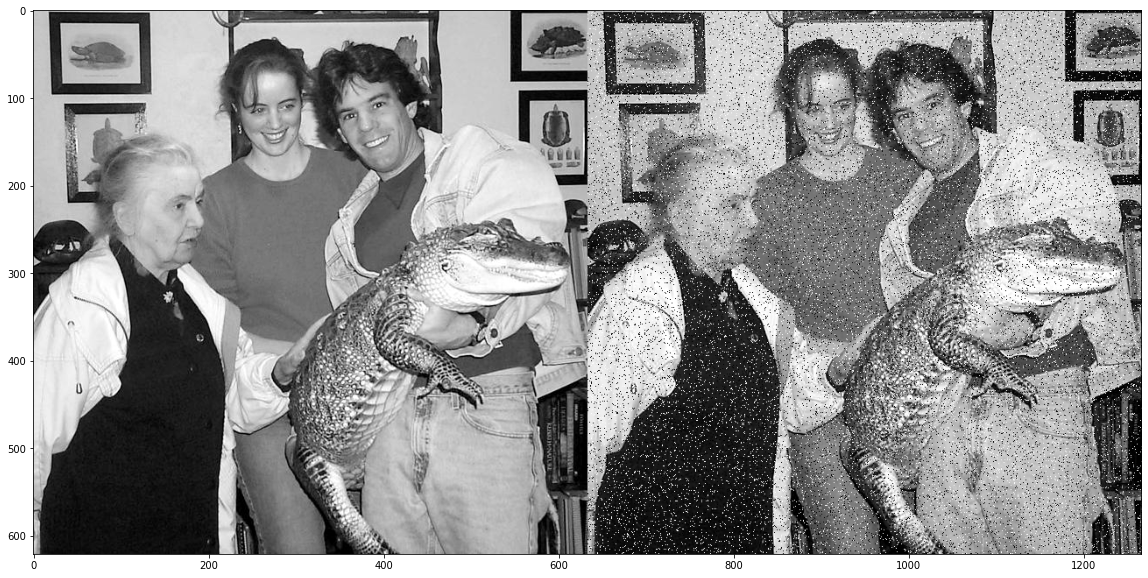

In [81]:
gator=lerimg('gator.pgm')
gator_snp=sp_noise(gator,0.05)
stack_img(gator,gator_snp)

Implementação do filtro da mediana na imagem gator com a presença de ruído do tipo sal e pimenta.


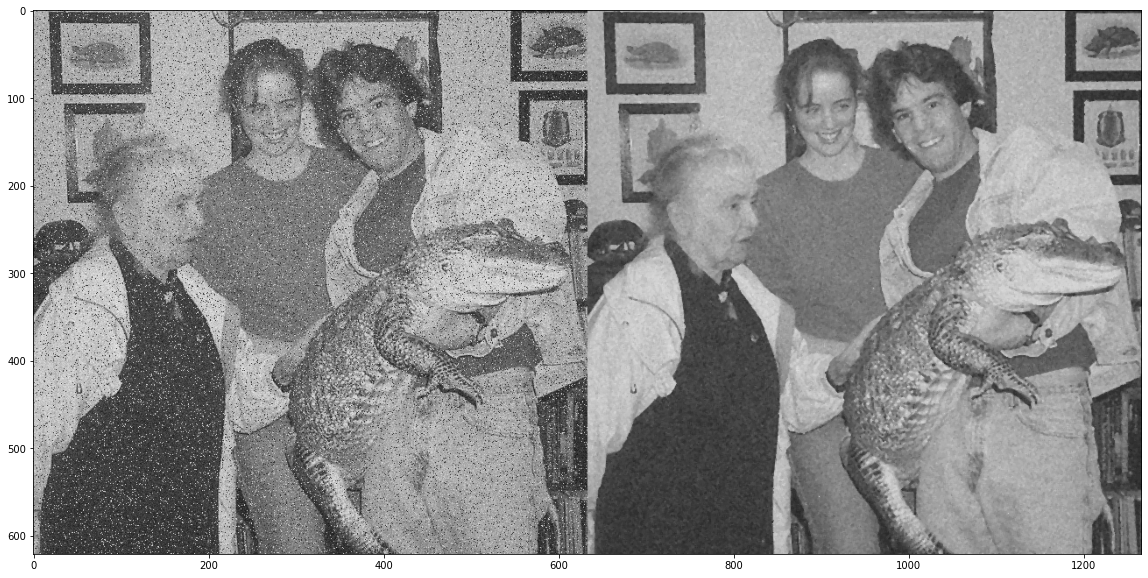

In [79]:
filter=filter_image(gator_snp,type="median",n=3,stack=True)

Comparação da imagem original "gator" com a imagem depois da passagem do filtro da mediana para retirada do ruído do tipo sal e pimenta. Observar o borramento.

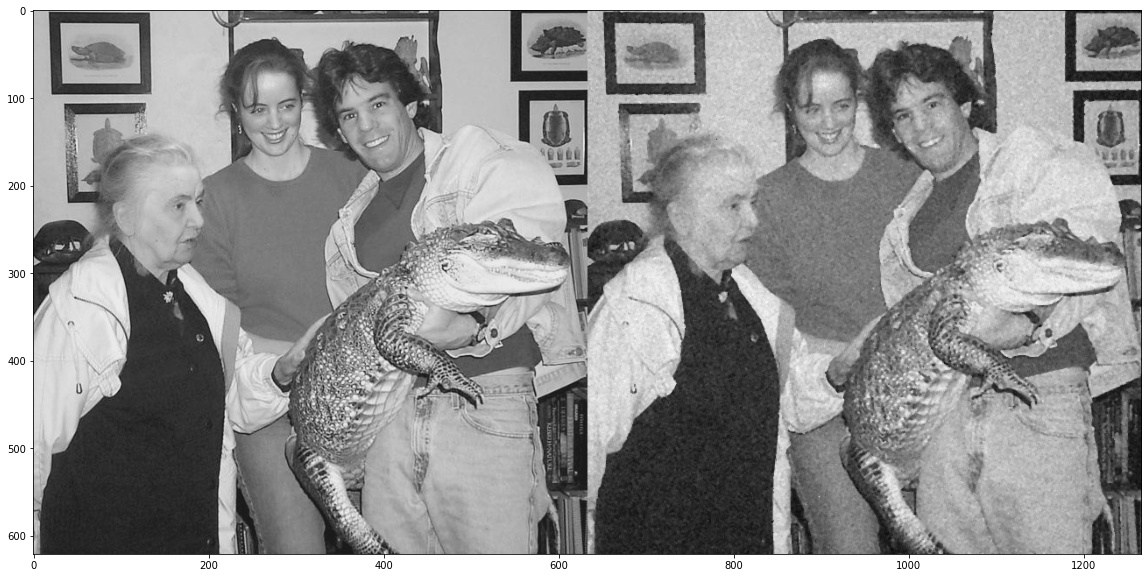

In [82]:
stack_img(gator,filter)

Implementação da rotina de filtragem para a imagem "gator". Primeiro foram adicionados, respectivamente, os ruídos do tipo gaussiano e do tipo sal e pimenta. Em seguida foi feita a filtragem com o filtro da mediana, seguido pelo filtro gaussiano e por último o filtro de wiener. É bem nítida a presença do borramento provocado pela filtragem.

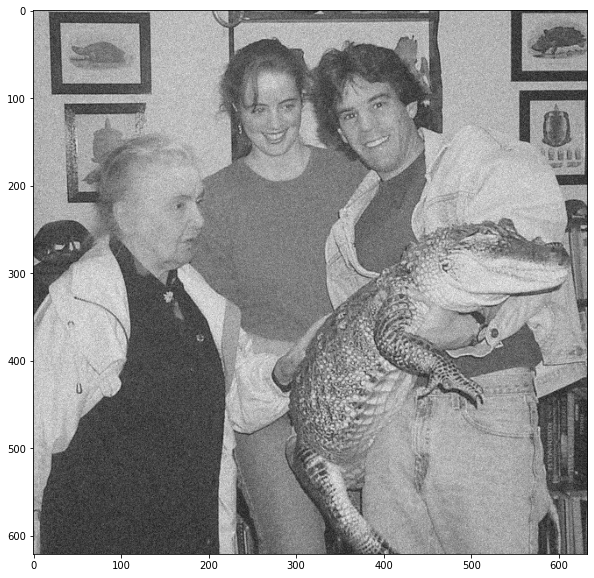

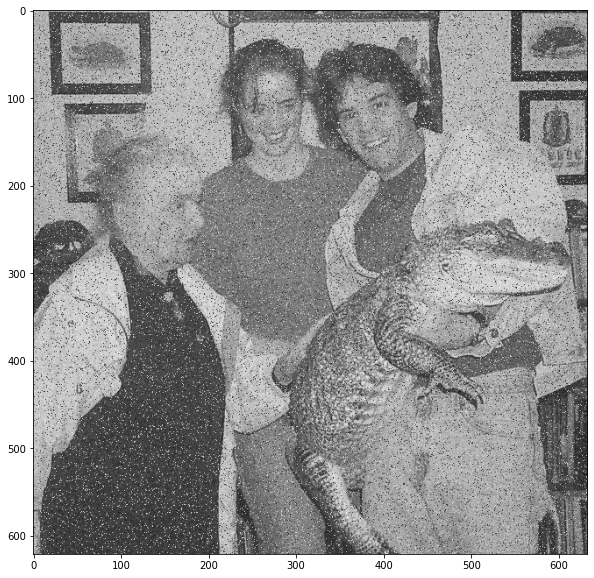

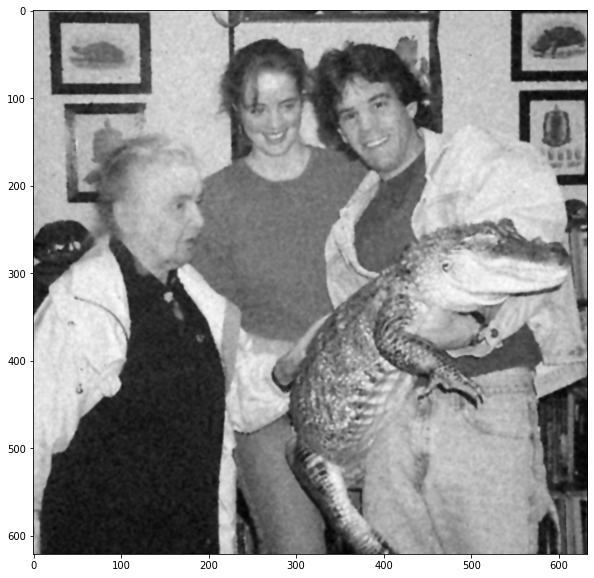

In [116]:
gator=lerimg('gator.pgm')
gator_gaussian=gaussian_noise(gator,0,20,printar=True)

gator_snp=sp_noise(gator_gaussian,0.05,printar=True)
gator_mediaana=filter_image(gator_snp,type="median",n=3,printar=False)
gator_gaussiano=filter_image(gator_mediaana,type="gaussian",n=3)
wiener=filter_image(gator_gaussiano,type='wiener',printar=True)



Aplicação do filtro de Wiener na imagem para remoção do ruído gaussiano.

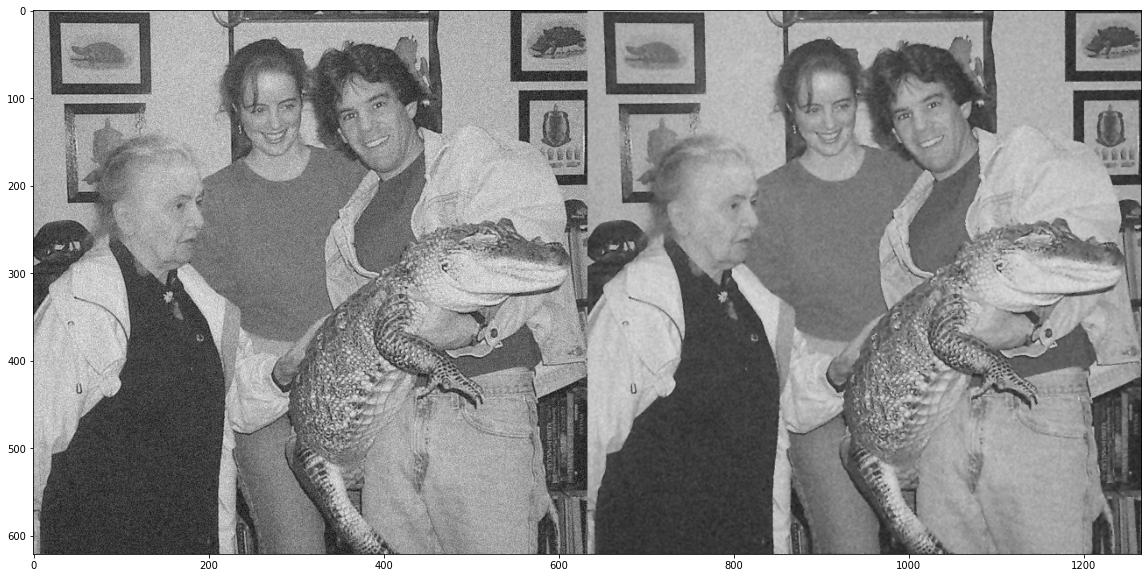

In [115]:
out=filter_image(gator_gaussian,'wiener',n=3,stack=True)
